In [62]:
import sys
sys.path.append("..")
import data_penn
import data_ptb
import numpy as np
import torch
import seaborn as sns
import tree_utils
import collections
import nltk
import os
import matplotlib as mpl
from nltk.parse import DependencyGraph
import matplotlib.pyplot as plt

device = 'cuda'

In [63]:
loaded_checkpoint = torch.load('../trained_models/2222.pt')

In [64]:
loaded_model = loaded_checkpoint[0]

In [65]:
loaded_model.eval()

StructFormer(
  (drop): Dropout(p=0.1, inplace=False)
  (emb): Embedding(10001, 512)
  (pos_emb): Embedding(500, 512)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (drop): Dropout(p=0, inplace=False)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (feedforward): Sequential(
        (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=512, out_features=2048, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=2048, out_features=512, bias=True)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dr

In [66]:
loaded_model.rel_weight.shape

torch.Size([8, 8, 2])

In [69]:
mask_bernoulli = torch.distributions.Bernoulli(0.3)
data = torch.LongTensor([ptb_corpus.test[412]]).to(device)
pos = torch.LongTensor([list(range(len(ptb_corpus.test[412])))]).to(device)

In [73]:
corpus = data_penn.Corpus('../data/penn')

Loading dictionary...


In [74]:
pad_token = corpus.dictionary.word2idx['<pad>']
mask_token = corpus.dictionary.word2idx['<mask>']
unk_token = corpus.dictionary.word2idx['<unk>']

In [75]:
def mask_data(data):
  """randomly mask input sequence."""
  mask = mask_bernoulli.sample(data.shape).to(device).bool()
  mask = mask * (data != pad_token) * (data != unk_token)
  targets = data.masked_fill(~mask, pad_token)
  data = data.masked_fill(mask, mask_token)
  return data, targets

In [76]:
data, targets = mask_data(data)

In [78]:
pad_token, mask_token, unk_token

(1, 2, 0)

In [77]:
data

tensor([[  0,   2, 252,   2,   2, 182,   2]], device='cuda:0')

In [79]:
targets

tensor([[   1,  160,    1, 2034,  102,    1, 8674]], device='cuda:0')

In [80]:
with torch.no_grad():
  logits = loaded_model(data, pos)

In [82]:
logits[0].shape

torch.Size([7, 10001])

In [83]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_token)

In [85]:
logits = logits[0]

In [90]:
logits.shape, targets.reshape(-1).shape

(torch.Size([7, 10001]), torch.Size([7]))

In [86]:
loss = criterion(logits, targets.reshape(-1))

In [88]:
loss

tensor(8.3731, device='cuda:0')

In [41]:
ptb_corpus = data_ptb.Corpus('../data/penn/')

In [42]:
len(ptb_corpus.test_sens), len(ptb_corpus.test_trees), len(ptb_corpus.test_nltktrees)

(2416, 2416, 2416)

In [43]:
ptb_corpus.test_sens[412]

['superconcentrates', 'are', "n't", 'entirely', 'new', 'for', 'p&g']

In [44]:
ptb_corpus.test[412]

[0, 160, 252, 2034, 102, 182, 8674]

In [45]:
ptb_corpus.test_trees[412]

['superconcentrates', ['are', "n't", ['entirely', 'new'], ['for', 'p&g']]]

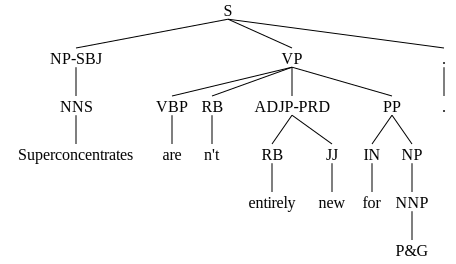

In [46]:
ptb_corpus.test_nltktrees[412]

In [47]:
import spacy
nlp = spacy.load("en_core_web_lg")
doc = nlp("Superconcentrates aren't entirely new for P&G.")
spacy.displacy.serve(doc, style="dep")

/home/omar/miniconda3/envs/structformer/lib/python3.6/site-packages/spacy/displacy/__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [48]:
data = torch.LongTensor([ptb_corpus.test[412]]).to(device)
pos = torch.LongTensor([list(range(len(ptb_corpus.test[412])))]).to(device)

In [49]:
data, pos

(tensor([[   0,  160,  252, 2034,  102,  182, 8674]], device='cuda:0'),
 tensor([[0, 1, 2, 3, 4, 5, 6]], device='cuda:0'))

In [50]:
with torch.no_grad():
    output, p_dict = loaded_model(data, pos)

In [51]:
output.shape, p_dict.keys()

(torch.Size([7, 10001]),
 dict_keys(['raw_output', 'distance', 'height', 'cibling', 'head', 'block']))

In [52]:
distance = p_dict['distance'].detach().clone().squeeze(0).cpu().numpy().tolist()
height = p_dict['height'].detach().clone().squeeze(0).cpu().numpy().tolist()

In [53]:
for d in distance:
    print(round(d, 3))

0.848
-0.208
-0.636
-0.339
0.233
0.151
1000000000.0


In [54]:
for h in height:
    print(round(h, 3))

0.943
-0.016
-0.065
0.515
0.33
0.151
1.294


In [55]:
parse_tree = tree_utils.build_tree(distance, ptb_corpus.test_sens[412])

In [57]:
parse_tree

['superconcentrates', [['are', [["n't", 'entirely'], 'new']], ['for', 'p&g']]]

In [58]:
model_out, _ = tree_utils.get_brackets(parse_tree)
model_out

{(1, 5), (1, 7), (2, 4), (2, 5), (5, 7)}

In [59]:
std_out, _ = tree_utils.get_brackets(ptb_corpus.test_trees[412])
std_out

{(1, 7), (3, 5), (5, 7)}

In [60]:
overlap = model_out.intersection(std_out)
overlap

{(1, 7), (5, 7)}

In [61]:
true_words = ptb_corpus.test_nltktrees[412].pos()
new_words = []
max_height = max(p_dict['height'][0])
for d, c, w, ph in zip(distance, height, ptb_corpus.test_sens[412], p_dict['head'][0].detach().cpu().numpy()):
    next_word = true_words.pop(0)
    while next_word[1] not in data_ptb.WORD_TAGS:
        next_word = true_words.pop(0)
    new_words.append({
            'address': len(new_words) + 1,
            'word': next_word[0],
            'lemma': None,
            'ctag': None,
            'tag': next_word[1],
            'feats': None,
            'head': np.argmax(ph) + 1 if c < max_height else 0,
            'deps': collections.defaultdict(list),
            'rel': None,
            'distance': d,
            'height': c
        })
    print(new_words[-1])

{'address': 1, 'word': 'Superconcentrates', 'lemma': None, 'ctag': None, 'tag': 'NNS', 'feats': None, 'head': 7, 'deps': defaultdict(<class 'list'>, {}), 'rel': None, 'distance': 0.8475630283355713, 'height': 0.9430140256881714}
{'address': 2, 'word': 'are', 'lemma': None, 'ctag': None, 'tag': 'VBP', 'feats': None, 'head': 7, 'deps': defaultdict(<class 'list'>, {}), 'rel': None, 'distance': -0.20808053016662598, 'height': -0.01571407914161682}
{'address': 3, 'word': "n't", 'lemma': None, 'ctag': None, 'tag': 'RB', 'feats': None, 'head': 4, 'deps': defaultdict(<class 'list'>, {}), 'rel': None, 'distance': -0.6360270977020264, 'height': -0.06527014821767807}
{'address': 4, 'word': 'entirely', 'lemma': None, 'ctag': None, 'tag': 'RB', 'feats': None, 'head': 7, 'deps': defaultdict(<class 'list'>, {}), 'rel': None, 'distance': -0.33850157260894775, 'height': 0.515226423740387}
{'address': 5, 'word': 'new', 'lemma': None, 'ctag': None, 'tag': 'JJ', 'feats': None, 'head': 7, 'deps': defaultdi

building the dep tree:
    
    for each word i:
        assign the head to the argmax of the head vector (i.e the word with the highest probability in Pd(j|i) where is the word we are currently looking at)

In [23]:
from nltk.parse import DependencyGraph
dtree = DependencyGraph()
for w in new_words:
    dtree.add_node(w)

In [24]:
print(dtree.to_conll(10))

1	The	None	None	DT	None	3	None	_	_
2	Dow	None	None	NNP	None	3	None	_	_
3	industrials	None	None	NNS	None	0	None	_	_
4	were	None	None	VBD	None	3	None	_	_
5	down	None	None	RB	None	7	None	_	_
6	55	None	None	CD	None	7	None	_	_
7	points	None	None	NNS	None	10	None	_	_
8	at	None	None	IN	None	10	None	_	_
9	3	None	None	CD	None	10	None	_	_
10	p.m.	None	None	RB	None	11	None	_	_
11	before	None	None	IN	None	14	None	_	_
12	the	None	None	DT	None	14	None	_	_
13	futures-trading	None	None	JJ	None	14	None	_	_
14	halt	None	None	NN	None	11	None	_	_



In [2]:
import numpy as np

In [8]:
import numpy as np

# Assuming your numpy list is named 'my_list'
my_list = np.array([1, 5, 3, 2, 4])

# Get the indices of the maximum 2 values
max_indices = np.argsort(my_list)[-2]

print(max_indices)


4


In [4]:
np.argmax(
    [1,2,3,4,5,6,7,8,9,10])

AxisError: axis 2 is out of bounds for array of dimension 1

In [25]:
tree_utils.get_dep(dtree, directed=True)

[('the', 'industrials'),
 ('dow', 'industrials'),
 ('industrials', '<s>'),
 ('were', 'industrials'),
 ('down', 'points'),
 ('55', 'points'),
 ('points', 'p.m.'),
 ('at', 'p.m.'),
 ('3', 'p.m.'),
 ('p.m.', 'before'),
 ('before', 'halt'),
 ('the', 'halt'),
 ('futures-trading', 'halt'),
 ('halt', 'before')]

In [ ]:
 with open(trg_file_path, 'r') as trg_file:
    trg_string = trg_file.read().strip()
    trg_string_list = trg_string.split('\n\n')
    try:
      trg_list = [
          DependencyGraph(t, top_relation_label='root') for t in trg_string_list
      ]
    except ValueError:

      def extract_10_cells(cells, index):
        line_index, word, lemma, tag, _, head, rel, _, _, _ = cells
        try:
          index = int(line_index)
        except ValueError:
          # index can't be parsed as an integer, use default
          pass
        return index, word, lemma, tag, tag, '', head, rel

      trg_list = [
          DependencyGraph(
              t, top_relation_label='root', cell_extractor=extract_10_cells)
          for t in trg_string_list
      ]

  correct = 0.0
  total = 0.0
  for prd, trg in zip(prd_list, trg_list):
    # assert len(prd.nodes) == len(trg.nodes)
    prd_deps = get_dep(prd, directed)
    trg_deps = get_dep(trg, directed)
    if len(prd_deps) != len(trg_deps):
      print(prd)
      print(prd_deps, len(prd_deps))
      print(trg)
      print(trg_deps, len(trg_deps))
      raise Exception

    for d in prd_deps:
      if d in trg_deps:
        correct += 1
    total += len(prd_deps)
  acc = correct / total

  if directed:
    print('DDA: %.3f' % acc)
  else:
    print('UDA: %.3f' % acc)
  return acc

In [29]:
words = ['<unk>', "are", "n't", 'entirely', 'new', 'for', 'p&g']

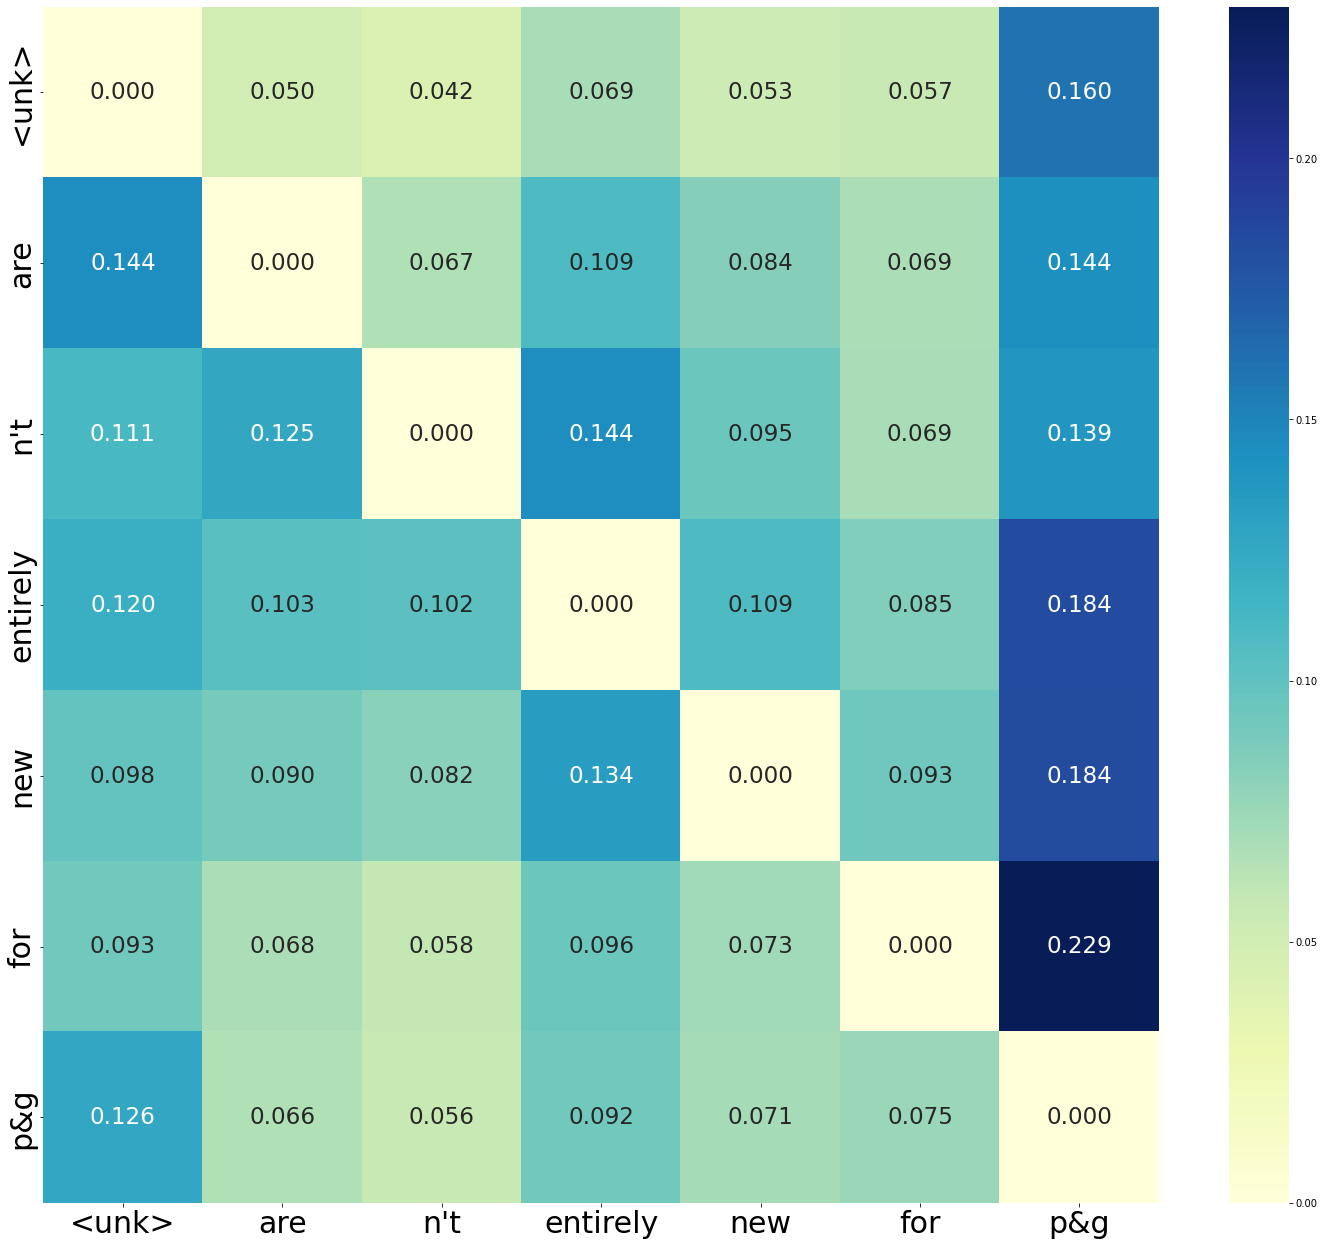

In [34]:
plt.figure(figsize=(25, 22))  # Set the figure size to 10 inches by 8 inches
heatmap = sns.heatmap(p_dict['head'][0].detach().cpu(), cmap="YlGnBu", annot=True, fmt=".3f", xticklabels=words, yticklabels=words, annot_kws={"fontsize": 23})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=30)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=30)
plt.savefig('heatmap.png')  # Save the figure as a PNG image
plt.show()


# plt.figure(figsize=(25, 22))  # Set the figure size to 10 inches by 8 inches
# heatmap = sns.heatmap(p_dict['head'][0].detach().cpu(), cmap="YlGnBu", annot=True, fmt=".3f", xticklabels=words, yticklabels=words)
# heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=23,)
# heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=23,)
# plt.savefig('heatmap.png')  # Save the figure as a PNG image
# plt.show()


# plt.figure(figsize=(25, 22))  # Set the figure size to 10 inches by 8 inches
# heatmap = sns.heatmap(p_dict['head'][0].detach().cpu(), cmap="YlGnBu", annot=True, fmt=".3f", xticklabels=words, yticklabels=words)
# heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=23,)
# heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=23,)
# plt.show()


# plt.figure(figsize=(15, 13))  # Set the figure size to 10 inches by 8 inches
# heatmap = sns.heatmap(p_dict['head'][0].detach().cpu(), cmap="YlGnBu", annot=False, xticklabels=words, yticklabels=words)
# heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=23, fontweight='bold')
# heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=23, fontweight='bold')
# plt.show()

In [30]:
loaded_model.rel_weight.shape

torch.Size([8, 8, 2])

In [31]:
loaded_model.rel_weight

tensor([[[0.5966, 0.4034],
         [0.6503, 0.3497],
         [0.5139, 0.4861],
         [0.5170, 0.4830],
         [0.4346, 0.5654],
         [0.4092, 0.5908],
         [0.6638, 0.3362],
         [0.4848, 0.5152]],

        [[0.5162, 0.4838],
         [0.6850, 0.3150],
         [0.4855, 0.5145],
         [0.3539, 0.6461],
         [0.4128, 0.5872],
         [0.3083, 0.6917],
         [0.4952, 0.5048],
         [0.4226, 0.5774]],

        [[0.4722, 0.5278],
         [0.4386, 0.5614],
         [0.4265, 0.5735],
         [0.5060, 0.4940],
         [0.4577, 0.5423],
         [0.5342, 0.4658],
         [0.4409, 0.5591],
         [0.3180, 0.6820]],

        [[0.4053, 0.5947],
         [0.4821, 0.5179],
         [0.4122, 0.5878],
         [0.3130, 0.6870],
         [0.3796, 0.6204],
         [0.4544, 0.5456],
         [0.4010, 0.5990],
         [0.4149, 0.5851]],

        [[0.3609, 0.6391],
         [0.5549, 0.4451],
         [0.4747, 0.5253],
         [0.5905, 0.4095],
         [0.2824, 0.